In [1]:
import json
from pathlib import Path
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from pprint import pprint
from binance import Client
import mt.resources.keys as keys
import statistics as stats

USDT Stats - Current Balance: 2260.80, Current Sharpe: -3.92, Average daily pnl : -22.63 / -1.00%, Annualised PnL: 2.54%
BTC Stats - Current Balance: 0.03381, Current Sharpe : -4.45, Average daily pnl : -0.00033 / -0.98%, Annualised PnL: 2.72%
Positions Stats - Smallest: 4.52 USDT, Largest: 60.29 USDT, Average: 26.73 USDT


<AxesSubplot: title={'center': 'Execution'}, xlabel='timestamp', ylabel='BPs'>

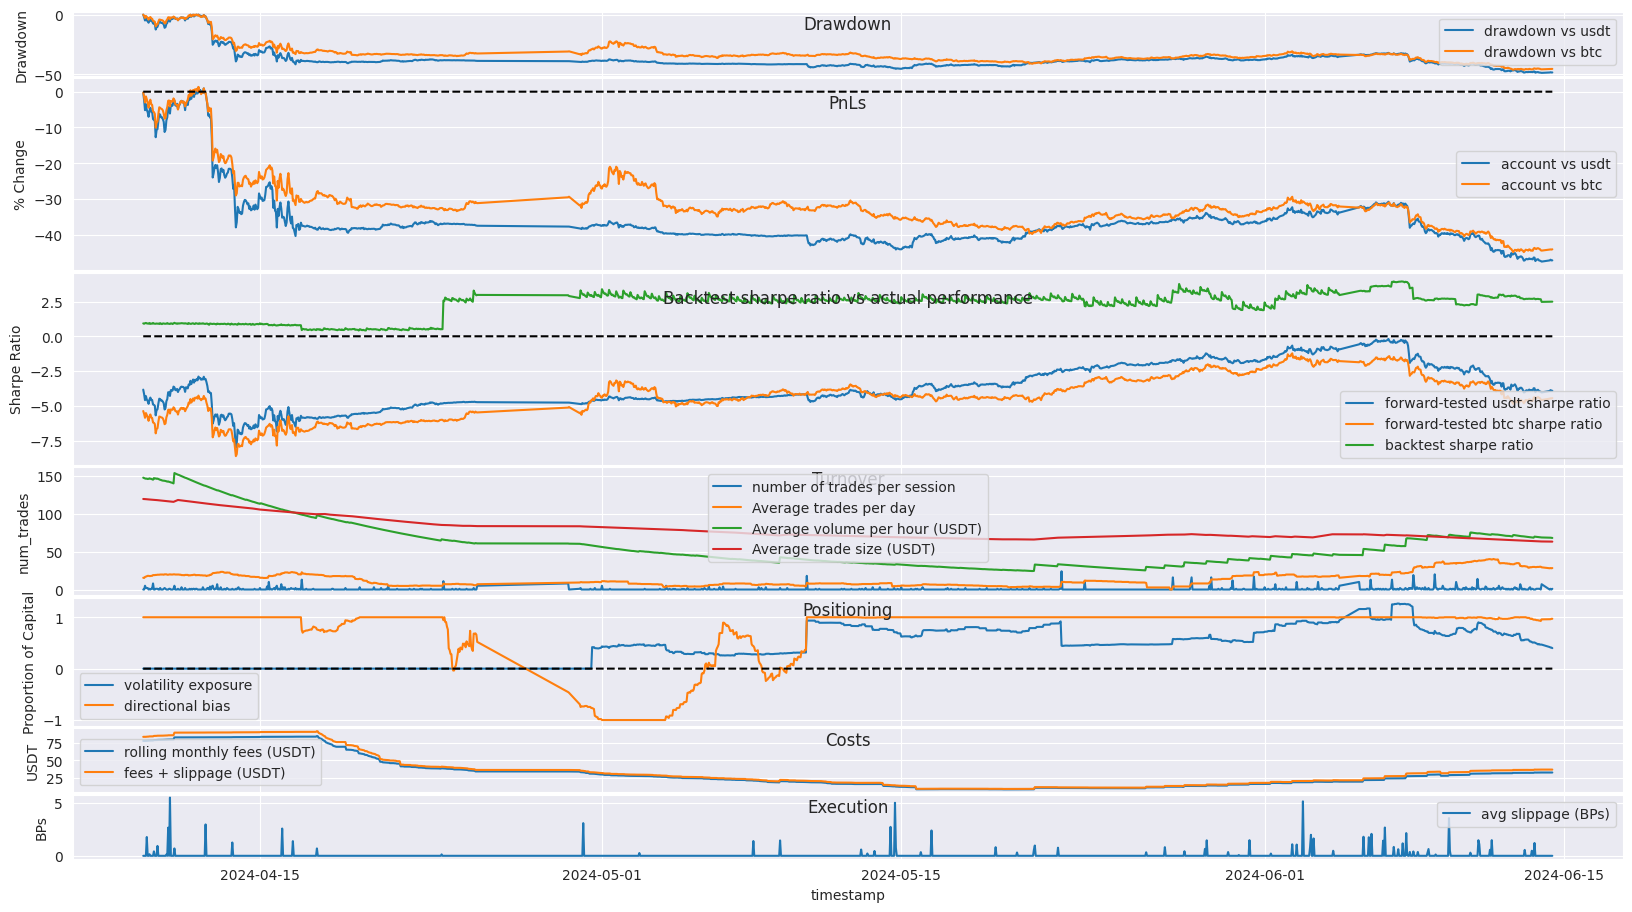

In [2]:
# TODO i want drawdown statistics like max dd, avg dd, max dd duration and avg dd duration and current dd duration - for the backtest and the live trading so i can compare
# TODO i want a breakdown for each coin that shows how much total pnl i have made (accounting for fees), total volume traded, avg pct profit per unit volume etc
# TODO i want some stats like avg pnl per day on a monthly rolling basis, total pnl since records began, average trade size, and more

sharpe_lb = 1440 # 168 = 1 week, 720 = 30 days, 2190 = 1Q, 8760 = 1 year
data_window = sharpe_lb

with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/trades.json"), 'r') as file:
    trades = json.load(file)
    
trade_df = pl.from_dicts(trades).with_columns(
    pl.col('timestamp').cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('executed_quote_size').cast(pl.Float32),
    pl.col('executed_quote_size').cast(pl.Float32).alias('avg_trade_size'),
    pl.col('desired_quote_size').mul(pl.col('price_impact')).alias('slippage_cost')
)

# resample to 1h
trades_1h = (
    trade_df
    .sort('timestamp')
    .group_by_dynamic(pl.col('timestamp'), every='1h')
    .agg(
        pl.sum('executed_quote_size'),
        pl.sum('usdt_fees'),
        pl.mean('price_impact'),
        pl.sum('slippage_cost'),
        pl.mean('avg_trade_size'),
    )
    .upsample(time_column='timestamp', every='1h')
    .fill_null(0.0)
)

# make the timeseries continuous from the start of the data to the present moment
start = trades_1h.item(0, 'timestamp')
trades_1h = pl.DataFrame(
    {
        "timestamp": pl.datetime_range(
            start=start,
            end=datetime.now(tz=timezone.utc),
            interval="1h",
            time_unit='ms',
            eager=True,
        )
    }
).lazy().join(trades_1h.lazy(), on="timestamp", how="left").fill_null(0).collect()

with open(Path("/home/ross/coding/pi_3/modular_trader/continuous/records/session.json"), 'r') as file:
    session_records = json.load(file)

for s in session_records:
    if s.get('volatility_exposure') is None:
        s['volatility_exposure'] = 0.0
    elif s.get('volatility_exposure') > 10:
        s['volatility_exposure'] = 0.9349222790015471
    if s.get('usdt_transfers') is None:
        s['usdt_transfers'] = 0.0
    if s.get('btc_transfers') is None:
        s['btc_transfers'] = 0.0
    if s.get('bt_sharpe') is None:
        s['bt_sharpe'] = 0.0
    if s.get('volatility_exposure') is None:
        s['volatility_exposure'] = 0.0

sr = pl.from_dicts(session_records).select([
    'timestamp', 'usdt_net', 'btc_net', 'trades', 'usdt_transfers', 'btc_transfers', 'bt_sharpe', 'volatility_exposure'
])

trades_1h = trades_1h.tail(len(sr))

sr = sr.with_columns(
    pl.col('usdt_net').diff().sub('usdt_transfers').alias('usdt_adjusted_diff'),
    pl.col('btc_net').diff().sub('btc_transfers').alias('btc_adjusted_diff'),
    pl.col('usdt_net').diff().sub('usdt_transfers').cum_sum().add(sr.item(0, 'usdt_net')).alias('usdt_adjusted_net'),
    pl.col('btc_net').diff().sub('btc_transfers').cum_sum().add(sr.item(0, 'btc_net')).alias('btc_adjusted_net'),
    trades_1h['executed_quote_size'].ewm_mean(span=720).alias('avg_hourly_volume'),
    trades_1h['usdt_fees'].rolling_sum(720, min_periods=2).alias('rolling_monthly_fees'),
    trades_1h['price_impact'].alias('avg_slippage'),
    trades_1h['slippage_cost'].alias('slippage_cost'),
    trades_1h['avg_trade_size'].replace(0.0, None).fill_null(strategy='forward').ewm_mean(span=sharpe_lb).alias('avg_trade_size'),
    trades_1h['slippage_cost'].rolling_sum(720, min_periods=2).alias('rolling_monthly_slippage_cost'),
)

allos = [s[f"{s.get('port_weights', 'flat')}_allocations"] for s in session_records]
abs_allos = [{k: abs(v) for k, v in i.items()} for i in allos]
bias_num = [sum(z.values()) for z in allos]
bias_denom = [sum(z.values()) for z in abs_allos]
bias = pl.Series([x/y for x, y in zip(bias_num, bias_denom)])

capital = [x['usdt_net'] for x in session_records]
both = zip(allos, capital)
sizes = [{k: (abs(v) * c) for k, v in a.items()} for a, c in both]
smallest = min(sizes[-1].values())
largest = max(sizes[-1].values())
avg_size = stats.mean(sizes[-1].values())

pred_exp = pl.Series([sum([abs(v) for v in z.values()]) for z in allos]) * 2

sr = sr.with_columns(
    (
        pl.col('usdt_adjusted_net')
        .pct_change()
        .ewm_mean(span=sharpe_lb, min_periods=48)
        .mul(8760)
        .truediv(
            pl.col('usdt_adjusted_net')
            .pct_change()
            .ewm_std(span=sharpe_lb, min_periods=48)
            .mul(92)
        )
        .alias('usdt_sharpe')
    ),
    (
        pl.col('btc_adjusted_net')
        .pct_change()
        .ewm_mean(span=sharpe_lb, min_periods=48)
        .mul(8760)
        .truediv(
            pl.col('btc_adjusted_net')
            .pct_change()
            .ewm_std(span=sharpe_lb, min_periods=48)
            .mul(92)
        )
        .alias('btc_sharpe')
    ),
).tail(data_window + sharpe_lb)

bias = bias.tail(len(sr))

sr = sr.with_columns(
    pl.col('timestamp').mul(1000).cast(pl.Int64).cast(pl.Datetime(time_zone='UTC', time_unit='ms')),
    pl.col('trades').alias('num_trades'),
    pl.col('trades').rolling_sum(96).truediv(4).alias('avg_trades'),
    bias.alias('bias'),
    
    # pred_exp.alias('pred_exp')
).tail(data_window)

sr = sr.with_columns(
    pl.col('usdt_adjusted_diff').truediv(sr.item(0, 'usdt_net')).cum_sum().mul(100).alias('usdt_pnl_pct'),
    pl.col('btc_adjusted_diff').truediv(sr.item(0, 'btc_net')).cum_sum().mul(100).alias('btc_pnl_pct'),
)

sr = sr.with_columns(
    pl.col('usdt_adjusted_diff').rolling_sum(24).ewm_mean(span=sharpe_lb).alias('usdt_avg_daily_pnl'),
    pl.col('btc_adjusted_diff').rolling_sum(24).ewm_mean(span=sharpe_lb).alias('btc_avg_daily_pnl'),
    pl.lit(0).sub(pl.col('usdt_pnl_pct').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('usdt_pnl_pct'))).alias('usdt_dd'),
    pl.lit(0).sub(pl.col('btc_pnl_pct').rolling_max(window_size=100_000, min_periods=1).sub(pl.col('btc_pnl_pct'))).alias('btc_dd'),
)

daily_usdt_pnl = sr.item(-1, 'usdt_avg_daily_pnl') / sr.item(-1, 'usdt_net')
ann_usdt_pnl = (daily_usdt_pnl + 1) ** 365
print(
    f"USDT Stats - Current Balance: {sr.item(-1, 'usdt_net'):.2f}, "
    f"Current Sharpe: {sr.item(-1, 'usdt_sharpe'):.2f}, "
    f"Average daily pnl : {sr.item(-1, 'usdt_avg_daily_pnl'):.2f} / {daily_usdt_pnl:.2%}, "
    f"Annualised PnL: {ann_usdt_pnl:.2%}"
)

daily_btc_pnl = sr.item(-1, 'btc_avg_daily_pnl') / sr.item(-1, 'btc_net')
ann_btc_pnl = (daily_btc_pnl + 1) ** 365
print(
    f"BTC Stats - Current Balance: {sr.item(-1, 'btc_net'):.5f}, "
    f"Current Sharpe : {sr.item(-1, 'btc_sharpe'):.2f}, "
    f"Average daily pnl : {sr.item(-1, 'btc_avg_daily_pnl'):.5f} / {daily_btc_pnl:.2%}, "
    f"Annualised PnL: {ann_btc_pnl:.2%}"
)
print(
    f"Positions Stats - Smallest: {smallest:.2f} USDT, Largest: {largest:.2f} USDT, Average: {avg_size:.2f} USDT"
)

fig, ax = plt.subplots(nrows=7, figsize=(20, 11), gridspec_kw=dict(height_ratios=[1, 3, 3, 2, 2, 1, 1]), sharex=True)
fig.subplots_adjust(hspace = 0.02)
ax[0].set_ylabel(ylabel='Drawdown')
ax[1].set_ylabel(ylabel='% Change')
ax[2].set_ylabel(ylabel='Sharpe Ratio')
ax[3].set_ylabel(ylabel=None)
ax[4].set_ylabel(ylabel='Proportion of Capital')
ax[5].set_ylabel(ylabel='USDT')
ax[6].set_ylabel(ylabel='BPs')

ax[0].set_title('Drawdown', y=0.6)
ax[1].set_title('PnLs', y=0.8)
ax[2].set_title('Backtest sharpe ratio vs actual performance', y=0.8)
ax[3].set_title('Turnover', y=0.8)
ax[4].set_title('Positioning', y=0.8)
ax[5].set_title('Costs', y=0.6)
ax[6].set_title('Execution', y=0.6)

sns.lineplot(data=sr, x='timestamp', y='usdt_dd', label='drawdown vs usdt', ax=ax[0])
sns.lineplot(data=sr, x='timestamp', y='btc_dd', label='drawdown vs btc', ax=ax[0])

sns.lineplot(data=sr, x='timestamp', y='usdt_pnl_pct', label='account vs usdt', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y='btc_pnl_pct', label='account vs btc', ax=ax[1])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[1])

sns.lineplot(data=sr, x='timestamp', y='usdt_sharpe', label='forward-tested usdt sharpe ratio', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y='btc_sharpe', label='forward-tested btc sharpe ratio', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y='bt_sharpe', label='backtest sharpe ratio', ax=ax[2])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[2])

sns.lineplot(data=sr, x='timestamp', y='num_trades', label='number of trades per session', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y='avg_trades', label='Average trades per day', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y='avg_hourly_volume', label='Average volume per hour (USDT)', ax=ax[3])
sns.lineplot(data=sr, x='timestamp', y='avg_trade_size', label='Average trade size (USDT)', ax=ax[3])

sns.lineplot(data=sr, x='timestamp', y='volatility_exposure', label='volatility exposure', ax=ax[4])
sns.lineplot(data=sr, x='timestamp', y='bias', label='directional bias', ax=ax[4])
# sns.lineplot(data=sr, x='timestamp', y='pred_exp', label='predicted exposure', ax=ax[4])
sns.lineplot(data=sr, x='timestamp', y=0, color='black', linestyle='--', ax=ax[4])

sns.lineplot(data=sr, x='timestamp', y='rolling_monthly_fees', label='rolling monthly fees (USDT)', ax=ax[5])
sns.lineplot(x=sr['timestamp'], y=sr['rolling_monthly_fees'] + sr['rolling_monthly_slippage_cost'], label='fees + slippage (USDT)', ax=ax[5])

sns.lineplot(x=sr['timestamp'], y=sr['avg_slippage']*10_000, label='avg slippage (BPs)', ax=ax[6])
# sns.lineplot(x=sr['timestamp'], y=sr['slippage_cost']*10_000, label='slippage cost (USDT)', ax=ax[6])




In [200]:
from binance.client import Client as Client_b
import mt.resources.keys as keys
client = Client_b(keys.bPkey, keys.bSkey)
m_acct = client.get_margin_account()

In [75]:
m_acct.keys()

dict_keys(['tradeEnabled', 'transferEnabled', 'borrowEnabled', 'marginLevel', 'totalAssetOfBtc', 'totalLiabilityOfBtc', 'totalNetAssetOfBtc', 'userAssets', 'collateralMarginLevel', 'totalCollateralValueInUSDT', 'accountType'])

In [76]:
m_acct['totalAssetOfBtc']

'0.04074035'

In [77]:
m_acct['totalNetAssetOfBtc']

'0.03900054'

In [186]:
start = test.item(0, 'timestamp')
test = pl.DataFrame(
    {
        "timestamp": pl.datetime_range(
            start=start,
            end=datetime.now(tz=timezone.utc),
            interval="1h",
            time_unit='ns',
            eager=True,
        )
    }
).lazy().join(test.lazy(), on="timestamp", how="left")


In [305]:
sr

timestamp,usdt_net,btc_net,trades,transfers,bt_sharpe,volatility_exposure,usdt_pnl_pct,btc_pnl_pct,usdt_avg_daily_pnl,btc_avg_daily_pnl,usdt_sharpe,btc_sharpe,usdt_dd,btc_dd,num_trades,avg_trades,avg_hourly_volume,rolling_monthly_fees,avg_slippage,bias
"datetime[ms, UTC]",f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f32,f64,f64,f64
2024-03-18 11:06:28.565 UTC,6859.096245,0.100803,3,0.0,0.0,0.0,1.0,1.0,null,null,null,null,1.0,1.0,3,null,412.172699,null,0.0,0.842526
2024-03-18 12:00:03.412 UTC,6891.908413,0.100984,1,0.0,0.0,0.0,1.004784,1.001789,null,null,null,null,1.0,1.0,1,null,2065.936035,3.094592,0.000022,0.594098
2024-03-18 13:00:06.123 UTC,6914.559595,0.100862,1,0.0,0.0,0.0,1.008086,1.000581,null,null,null,null,1.0,0.998794,1,null,1731.207031,3.89375,0.000013,0.690836
2024-03-18 14:00:05.711 UTC,6714.302316,0.099364,1,0.0,0.0,0.0,0.97889,0.985726,null,null,null,null,0.971038,0.983966,1,null,1457.407104,4.373878,0.000094,0.720254
2024-03-18 15:00:06.121 UTC,6603.252314,0.098826,1,0.0,0.0,0.0,0.9627,0.980379,null,null,null,null,0.954978,0.978628,1,null,1215.992188,4.566924,0.0,0.726769
2024-03-18 16:00:04.794 UTC,6683.814322,0.099151,2,0.0,0.0,0.0,0.974445,0.983607,null,null,null,null,0.966629,0.981851,2,null,1312.025635,5.908056,0.0,0.486299
2024-03-18 17:00:04.175 UTC,6645.976971,0.099107,2,0.0,0.0,0.0,0.968929,0.983176,null,null,null,null,0.961157,0.98142,2,null,1265.992554,6.651817,0.0,0.564524
2024-03-18 18:00:04.939 UTC,6604.235147,0.097973,2,0.0,0.0,0.0,0.962843,0.971924,null,null,null,null,0.95512,0.970188,2,null,1174.32666,7.056651,0.0,0.611361
2024-03-18 19:00:03.813 UTC,6566.149942,0.097949,2,0.0,0.0,0.0,0.957291,0.971685,null,null,null,null,0.949612,0.96995,2,null,1098.399902,7.430388,0.000023,0.620286
